In [1]:
import json

In [58]:
def update_startup_times_overall_labels(startup_times_overall):
    longarg_to_shortname = {
        '--exit-after-startup':                        '',
        '--disable-builtin-cli-modules':               'no_cli',
        '--disable-builtin-loadable-modules':          'no_loadable',
        '--disable-builtin-scripted-loadable-modules': 'no_scripted',
        '--disable-python':                            'no_python',
        '--disable-modules':                           'no_modules'
    }

    updated = {}
    for (case, duration) in startup_times_overall.items():
        updated_case = []
        for part in case.split(' '):
            if part in longarg_to_shortname:
                part = longarg_to_shortname[part]
            if part:
                updated_case.append(part)
        # Make sure "no_python" is last to facilitate comparison
        if 'no_python' in updated_case:
            updated_case.append(updated_case.pop(updated_case.index('no_python')))
        updated_case = "+".join(updated_case)
        
        if updated_case == '':
            updated_case = 'all_modules'
        if updated_case == 'no_python':
            updated_case = 'all_modules+no_python'
        updated[updated_case] = duration
    return updated

In [63]:
startup_times_overall = {}

for dataset in ['baseline', 'r25079', 'r25104', 'r25122-with-optim-2']:
    with open("05_data/StartupTimes-%s.json" % dataset) as stats:
        startup_times_overall[dataset] = update_startup_times_overall_labels(json.load(stats))

In [64]:
import pandas as pd

df = pd.DataFrame.from_dict(startup_times_overall, orient='index')
df = df.T.sort_index()
df

,baseline,r25079,r25104,r25122-with-optim-2
all_modules,8.130485,5.596378,3.955679,2.368188
all_modules+no_python,5.617183,3.125620,1.601381,2.027286
no_cli,5.481303,5.420806,3.899789,2.326870
no_cli+no_python,3.073569,3.056184,1.536836,1.964021
no_cli+no_scripted,3.861735,3.871852,2.346061,1.985299
no_cli+no_scripted+no_python,3.053162,3.037926,1.526005,1.981598
no_loadable,5.368830,2.891642,2.840553,1.659645
no_loadable+no_python,3.338500,0.877658,0.886157,0.907729
no_modules,1.660642,1.684648,1.720631,1.317908
no_modules+no_python,0.836282,0.838093,0.834457,0.856326


In [5]:
# df_improvements = pd.DataFrame(1 - df['r25079'] / df['baseline'], columns=['r25079'])

# df_improvements['r25104'] = (1 - df['r25104'] / df['r25079'])

# df_improvements['overall'] = (1 - df['r25104'] / df['baseline'])

# df_improvements.round(2)

In [61]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

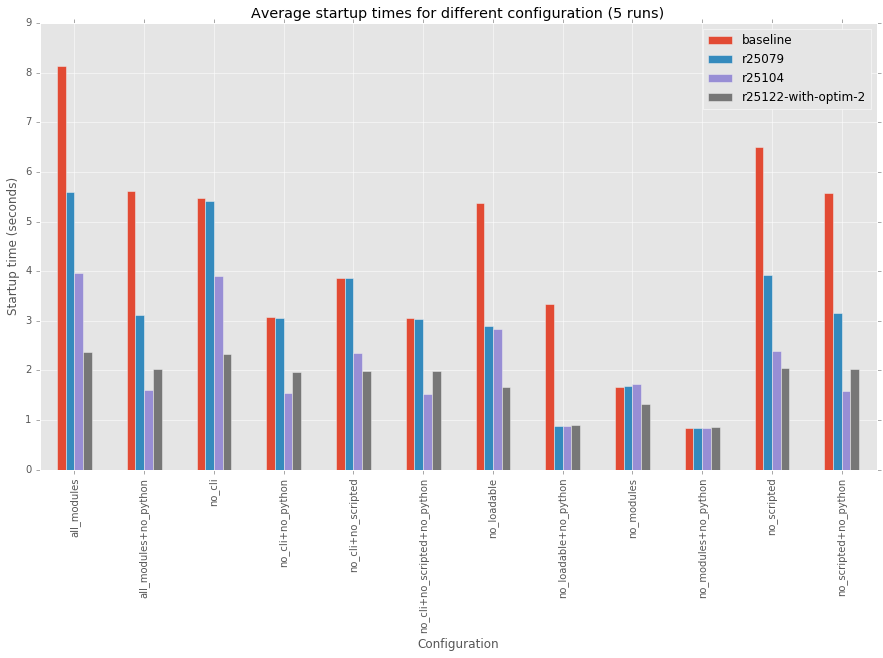

In [65]:
ax = df.plot.bar(use_index=True, legend=True,
                   figsize=(15, 8),
                   title="Average startup times for different configuration (5 runs)")
ax.set_xlabel("Configuration")
ax.set_ylabel("Startup time (seconds)")

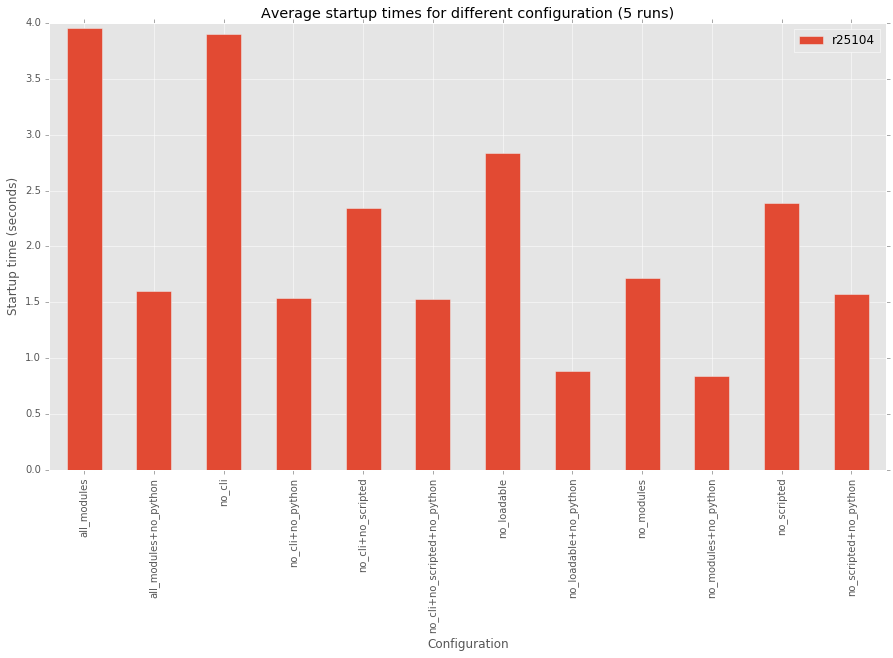

In [8]:
ax = df.loc[:, 'r25104'].plot.bar(use_index=True, legend=True,
                   figsize=(15, 8),
                   title="Average startup times for different configuration (5 runs)")
ax.set_xlabel("Configuration")
ax.set_ylabel("Startup time (seconds)")

In [9]:
dataset = 'r25079'

with open("05_data/StartupTimesExcludingOneModule-%s.json" % dataset) as stats:
    startup_times_excluding_one_module = json.load(stats)

In [10]:
df_times = pd.DataFrame.from_dict(startup_times_excluding_one_module, orient='index')
df_times.columns = ['time']

In [11]:
with open("05_data/Modules-%s.json" % dataset) as stats:
    module_to_module_type = json.load(stats)

In [12]:
df_types = pd.DataFrame.from_dict(module_to_module_type, orient='index')
df_types.columns = ['type']

In [13]:
df = pd.merge(df_times, df_types, left_index=True, right_index=True)

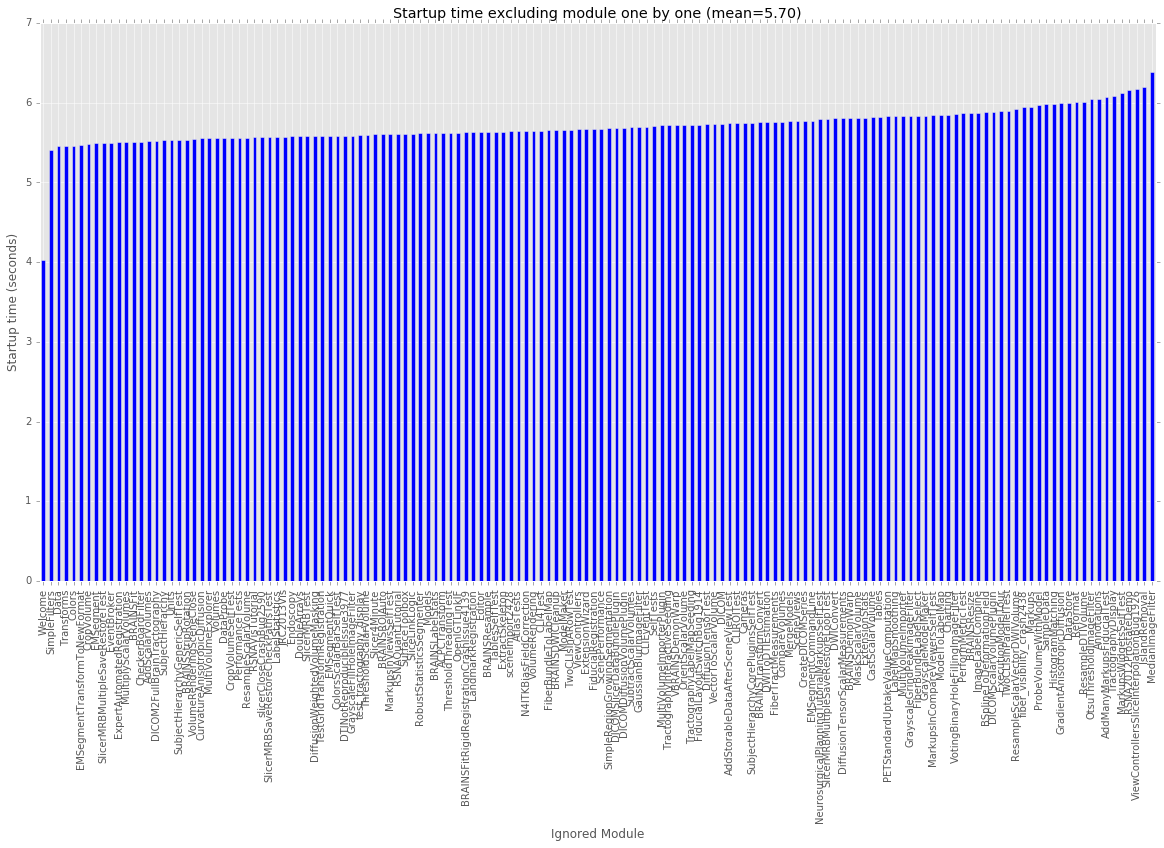

In [14]:
import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time excluding module one by one (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Ignored Module")
ax.set_ylabel("Startup time (seconds)")

(df.time.sort_values()
      #.head(30)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))

In [67]:
def load_startuptimes_including_one_module(dataset):

    with open("05_data/StartupTimesIncludingOneModule-%s.json" % dataset) as stats:
        startup_times_excluding_one_module = json.load(stats)

    df_times = pd.DataFrame.from_dict(startup_times_excluding_one_module, orient='index')
    df_times.columns = ['time']

    with open("05_data/Modules-%s.json" % dataset) as stats:
        module_to_module_type = json.load(stats)

    df_types = pd.DataFrame.from_dict(module_to_module_type, orient='index')
    df_types.columns = ['type']

    return pd.merge(df_times, df_types, left_index=True, right_index=True)

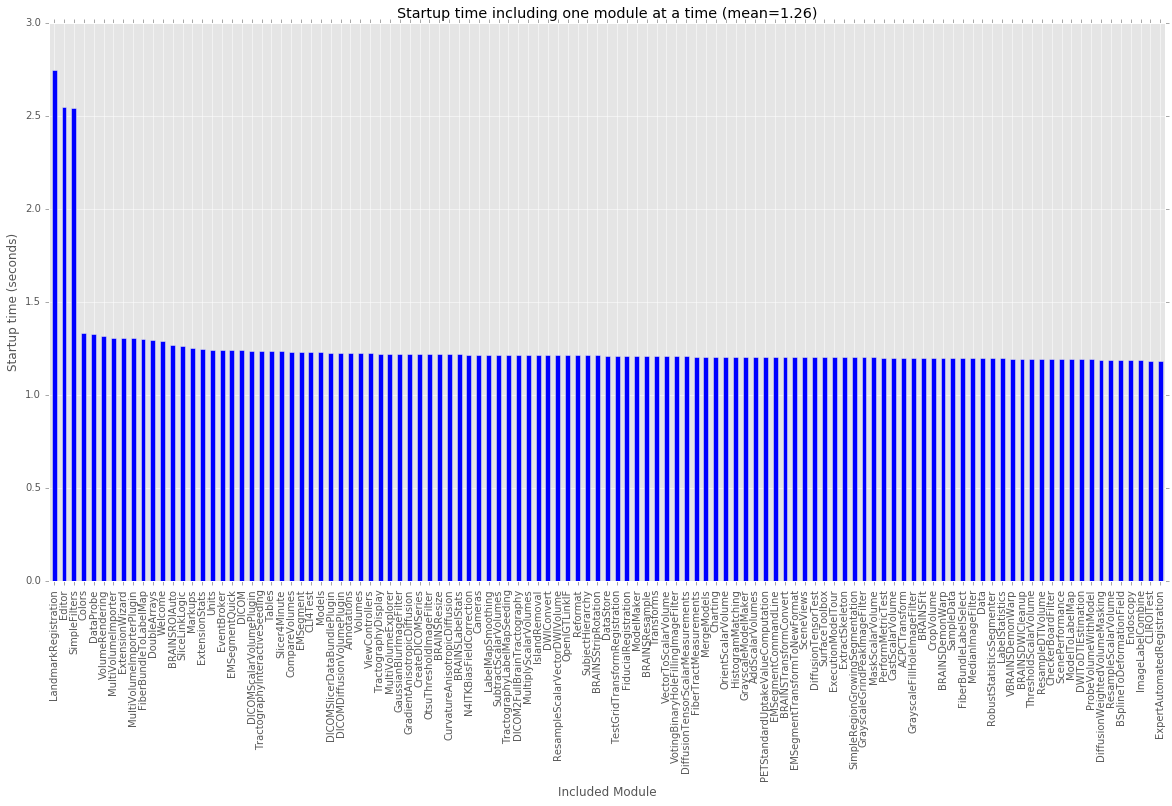

In [68]:
import json
import pandas as pd

dataset = 'r25122'
df = load_startuptimes_including_one_module("%s-with-lazy-load-of-wrapping" % dataset)

import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time including one module at a time (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Included Module")
ax.set_ylabel("Startup time (seconds)")

ax = (df.time.sort_values(ascending=False)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))
ax.set_ylim([0,3]);

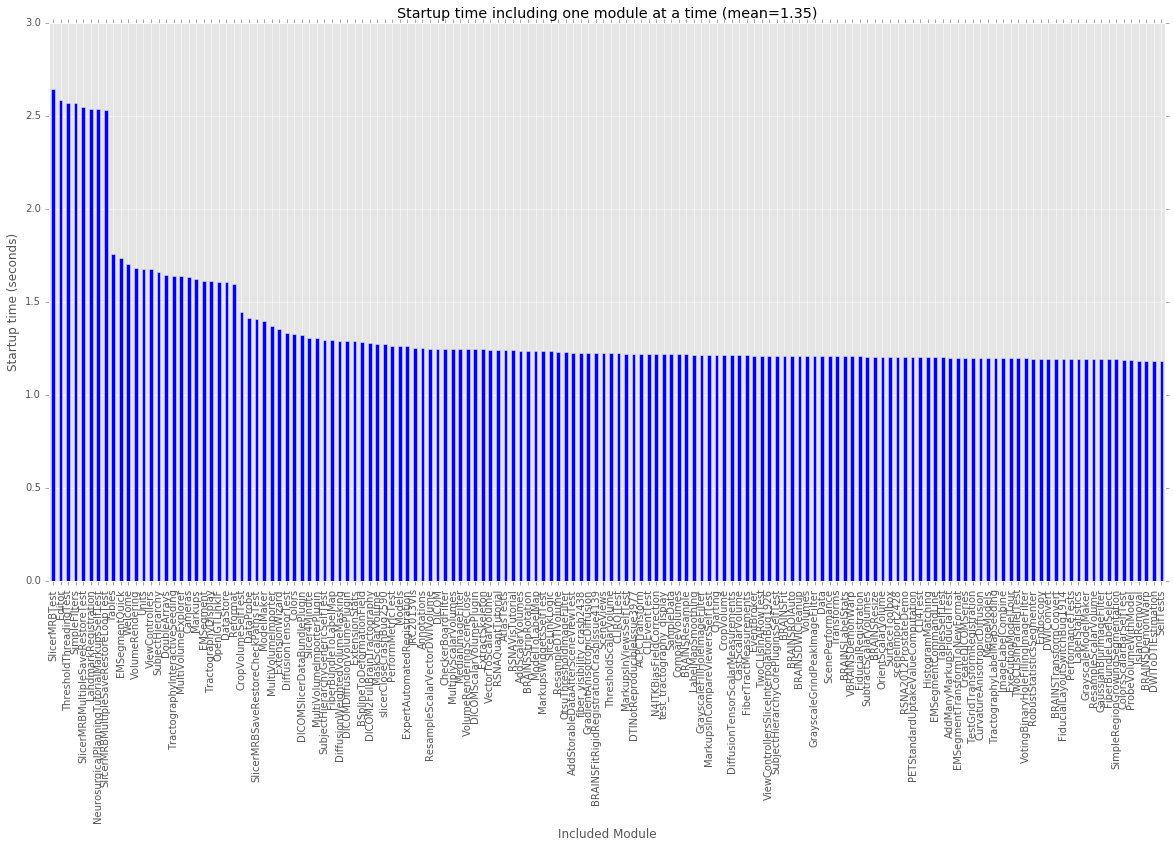

In [55]:
import json
import pandas as pd

dataset = 'r25122'
df = load_startuptimes_including_one_module("%s-simplify-import" % dataset)

import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time including one module at a time (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Included Module")
ax.set_ylabel("Startup time (seconds)")

ax = (df.time.sort_values(ascending=False)
      #.head(50)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))
ax.set_ylim([0,3]);

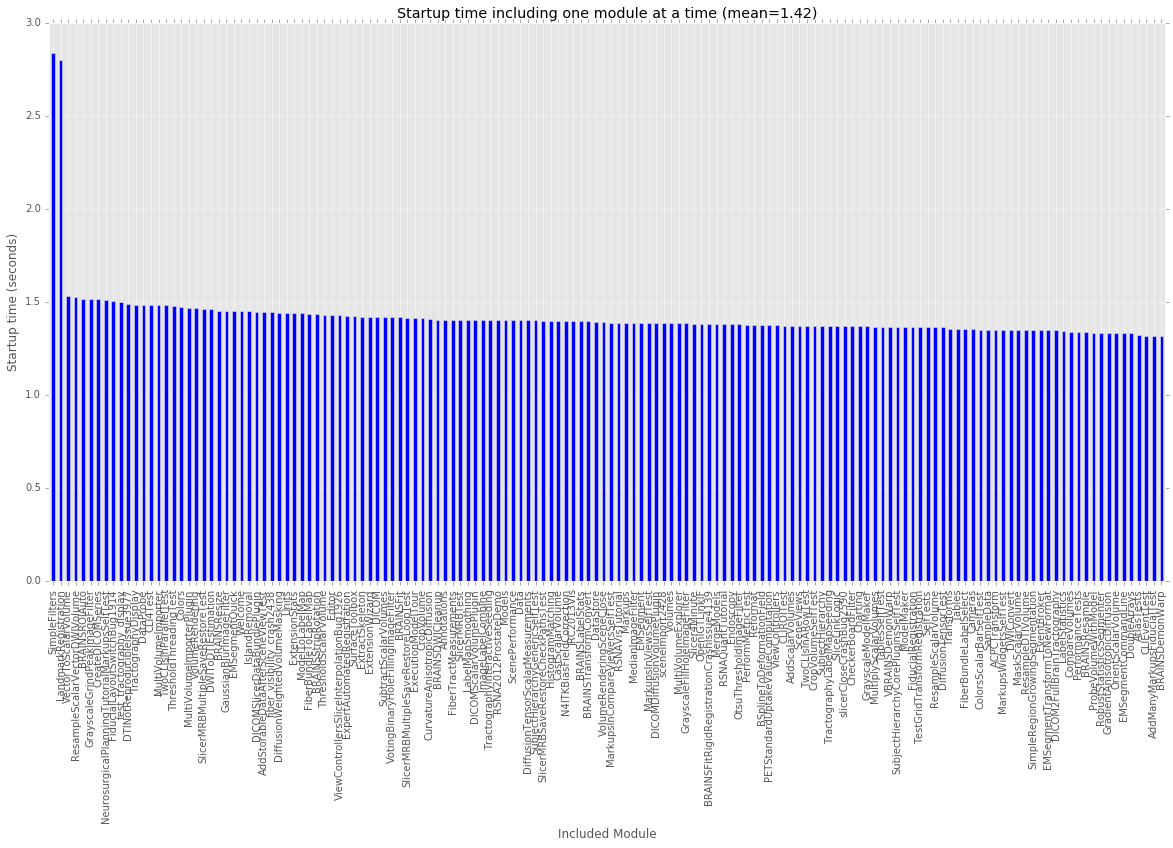

In [56]:
import json
import pandas as pd

dataset = 'r25122'
df = load_startuptimes_including_one_module("%s-with-optim" % dataset)

import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time including one module at a time (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Included Module")
ax.set_ylabel("Startup time (seconds)")

ax = (df.time.sort_values(ascending=False)
      #.head(50)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))
ax.set_ylim([0,3]);

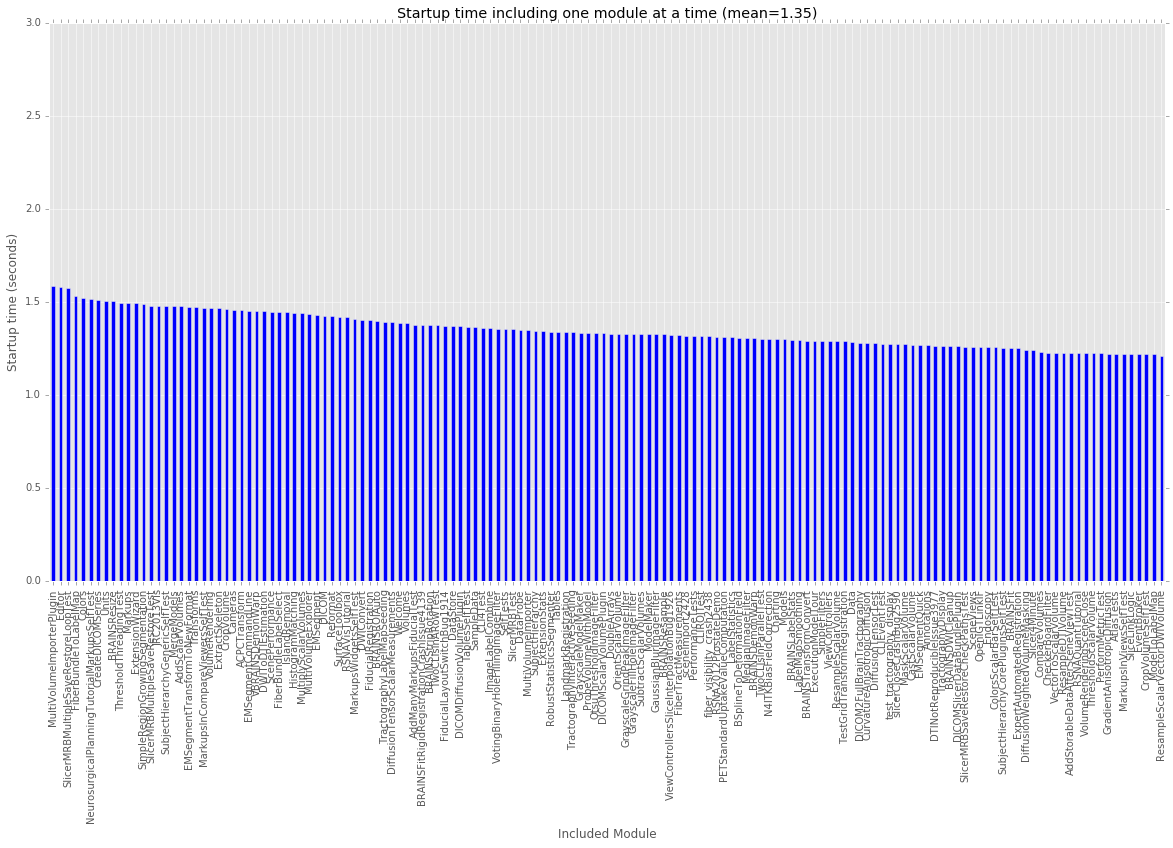

In [57]:
import json
import pandas as pd

dataset = 'r25122'
df = load_startuptimes_including_one_module("%s-with-optim-2" % dataset)

import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time including one module at a time (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Included Module")
ax.set_ylabel("Startup time (seconds)")

ax = (df.time.sort_values(ascending=False)
      #.head(50)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))
ax.set_ylim([0,3]);